## Importing basic libraries

In [1]:
import numpy as np
import pandas as pd
import string
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import glob
import cufflinks as cf # cufflinks to link plotly to pandas and add the iplot method
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Importing Language Model Libraries

In [ ]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
from tqdm import tqdm
from rank_bm25 import BM25Okapi, BM25, BM25L, BM25Plus

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
from gensim.models.ldamulticore import LdaMulticore
import os
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel

from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

In [4]:
from nltk.stem.porter import PorterStemmer 
from nltk.util import ngrams

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
additional_stop_words = ['porsche,' 'mercede','comfortsport', 'mercedes','mercedes-benz', 'honda','toyota','audi', 'benz','bentley','lexus',
                  'nissan','volvo','drive','nt','vehicle','infiniti','miles','corvette','come','edmund','lotus','diego','snake',
                 'porsche', 'cayman','bought','year','minute','chicago','car','home', 'think','suv','people','edmunds',
                  'cabriolet','lexuss','japan','husband','baby','range', 'rover','cadillac','cadillacs','michelin','texas',
                   'awsome','one','now', 'take', 'give', 'new','levinson','road','sedan','wife','sport','bang','tank',
                   'truck','lemon','imho','pathfinder','infinity','convertible','allroad','conv','bike','ski','grocery','mclass'
                  ,'hardtop','club','hubby','child','zoom','etc','brain','ashamed','carmax','alpina','rocketship','germany',
                  'autobahn','mercedez','000','great','good','just','ve','like','--','!!','\'','mustang','ive','gt','lt']

stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

## Data Pre-processing

In [ ]:
base_path = 'edmundsconsumer-car-ratings-and-reviews/'
reviewDocs = glob.glob(base_path + '*.csv')

In [ ]:
result= pd.DataFrame()

for i in reviewDocs:
    temp = pd.read_csv(i, engine='python', index_col=False, encoding = 'utf8')
    result = result.append(temp)

#drop NA
result = result.dropna()
#drop unnamed column
result = result.drop(['Unnamed: 0'], axis = 1)

#split vehicle name column to year, make and model columns
result['year'] = result.Vehicle_Title.str.split(' ').apply(lambda x:x[0])
result['make'] = result.Vehicle_Title.str.split(' ').apply(lambda x:x[1])
result['model'] = result.Vehicle_Title.str.split(' ').apply(lambda x:x[2])

#round Customer Rating to one decimal places
result['Rating'] = result['Rating'].apply(lambda x: round(x, 1))

#concatenate Review Title and Review Text
result['EntireReview'] = result["Review_Title"].map(str) + result["Review"]

In [ ]:
#Save pre-processed CSV
result.to_csv('CarReviews.csv',index=False)

In [7]:
carReviews = pd.read_csv('CarReviews.csv')

In [8]:
carReviews.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,year,make,model,EntireReview
0,on 08/09/18 10:25 AM (PDT),Becky - grandma,2018 Buick Envision SUV Premium II 4dr SUV AWD...,Fantastic Ride,Could have a little more cargo space. Front c...,5.0,2018,Buick,Envision,Fantastic Ride Could have a little more cargo ...
1,on 06/03/18 21:39 PM (PDT),Ron Consiglio,2018 Buick Envision SUV Essence 4dr SUV AWD (2...,Perception is not always reality,My Buick Envision is an excellent machine. It...,5.0,2018,Buick,Envision,Perception is not always reality My Buick Envi...
2,on 06/08/18 06:19 AM (PDT),Anne,2017 Buick Envision SUV Premium II 4dr SUV AWD...,Love this car - Great value,I reviewed all types of cars and once I set m...,5.0,2017,Buick,Envision,Love this car - Great value I reviewed all typ...
3,on 05/28/18 08:02 AM (PDT),Eric,2017 Buick Envision SUV Essence 4dr SUV AWD (2...,The Essence!,I really like this little SUV / Crossover. T...,5.0,2017,Buick,Envision,The Essence! I really like this little SUV / C...
4,on 05/25/18 06:57 AM (PDT),Ernest,2017 Buick Envision SUV 4dr SUV (2.5L 4cyl 6A),Auto stop,"The auto stop , when engaged and taking the f...",4.0,2017,Buick,Envision,"Auto stop The auto stop , when engaged and tak..."


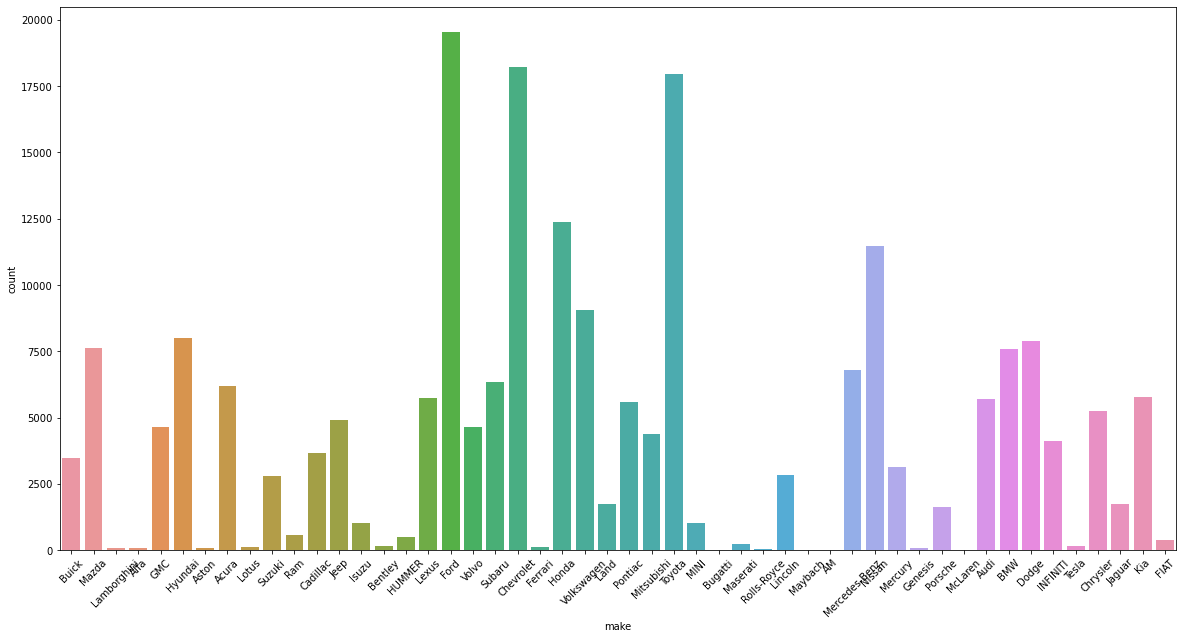

In [9]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.xticks(rotation=45)
sns.countplot(x="make", data=carReviews)

In [10]:
models= ['Ford','Chevrolet','Toyota','Honda','Nissan']
carReviews = carReviews[carReviews['make'].isin(models)]
carReviews.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,year,make,model,EntireReview
49588,on 06/06/18 14:19 PM (PDT),Vicki,2006 Ford Mustang Coupe GT Premium 2dr Coupe (...,2006 Mustang GT,Doesn’t disappoint,5.0,2006,Ford,Mustang,2006 Mustang GT Doesn’t disappoint
49589,on 08/12/17 06:06 AM (PDT),Tom,2006 Ford Mustang Coupe V6 Standard 2dr Coupe ...,DREAM CAR,I bought mine 4/17 with 98K. Have been wantin...,3.0,2006,Ford,Mustang,DREAM CAR I bought mine 4/17 with 98K. Have be...
49590,on 06/15/17 05:43 AM (PDT),Ray,2006 Ford Mustang Coupe V6 Premium 2dr Coupe (...,Great Ride,There will always be a 05-09 mustang for sale...,5.0,2006,Ford,Mustang,Great Ride There will always be a 05-09 mustan...
49591,on 05/18/17 17:33 PM (PDT),Don Watson,2006 Ford Mustang Coupe V6 Deluxe 2dr Coupe (4...,I have wanted a Mustang for 40 years.,I bought my car from an auction I work at ( A...,5.0,2006,Ford,Mustang,I have wanted a Mustang for 40 years. I bought...
49592,on 01/03/16 18:03 PM (PST),One owner,2006 Ford Mustang Coupe GT Premium 2dr Coupe (...,One owner,I bought this car spankin new and i still am ...,5.0,2006,Ford,Mustang,One owner I bought this car spankin new and i ...


In [11]:
carReviews['Rating'].iplot(
    kind='hist',
    xTitle='Rating',
    linecolor='black',
    yTitle='Count',
    title='Distribution of Review Ratings')

In [12]:
def lematized_review(text): # text
    rev_text = nlp(text)
    rev_text = ([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in stop_words and not token.is_punct and len(token.text) > 3])
    return rev_text

In [13]:
def preprocess(review):
    # converts to lower case
    review = review.lower()
    # removes URLs
    review = review.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
    review = review.replace(r'www\.\S+\.com','')
    # removes user mention
    review = review.replace(r'@\S+', '')
    # removes html tags
    review = review.replace(r'<.*?>', '')
    # removes extra spaces
    review = review.replace(r' +', ' ')
    # removes punctuations
    review = review.replace('[{}]'.format(string.punctuation), '')
    review = review.translate(str.maketrans('','', string.punctuation))
    review = review.strip()
    return review

In [14]:
carReviews['CleanReview'] = carReviews['EntireReview'].apply(lambda x:preprocess(x))

In [15]:
carReviews['ReviewTokens'] = carReviews['CleanReview'].apply(lambda x:lematized_review(x))

In [16]:
carReviews.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,year,make,model,EntireReview,CleanReview,ReviewTokens
49588,on 06/06/18 14:19 PM (PDT),Vicki,2006 Ford Mustang Coupe GT Premium 2dr Coupe (...,2006 Mustang GT,Doesn’t disappoint,5.0,2006,Ford,Mustang,2006 Mustang GT Doesn’t disappoint,2006 mustang gt doesn’t disappoint,"[2006, disappoint]"
49589,on 08/12/17 06:06 AM (PDT),Tom,2006 Ford Mustang Coupe V6 Standard 2dr Coupe ...,DREAM CAR,I bought mine 4/17 with 98K. Have been wantin...,3.0,2006,Ford,Mustang,DREAM CAR I bought mine 4/17 with 98K. Have be...,dream car i bought mine 417 with 98k have been...,"[dream, want, 0509, vintage, year, engine, fin..."
49590,on 06/15/17 05:43 AM (PDT),Ray,2006 Ford Mustang Coupe V6 Premium 2dr Coupe (...,Great Ride,There will always be a 05-09 mustang for sale...,5.0,2006,Ford,Mustang,Great Ride There will always be a 05-09 mustan...,great ride there will always be a 0509 mustang...,"[ride, 0509, sale, fairly, reasonable, purchas..."
49591,on 05/18/17 17:33 PM (PDT),Don Watson,2006 Ford Mustang Coupe V6 Deluxe 2dr Coupe (4...,I have wanted a Mustang for 40 years.,I bought my car from an auction I work at ( A...,5.0,2006,Ford,Mustang,I have wanted a Mustang for 40 years. I bought...,i have wanted a mustang for 40 years i bought ...,"[want, year, auction, work, adesa, sacramento,..."
49592,on 01/03/16 18:03 PM (PST),One owner,2006 Ford Mustang Coupe GT Premium 2dr Coupe (...,One owner,I bought this car spankin new and i still am ...,5.0,2006,Ford,Mustang,One owner I bought this car spankin new and i ...,one owner i bought this car spankin new and i ...,"[owner, spankin, love, hug, moment, notice, th..."


# Review Analysis Part 1

## BM25 Okapi to retrieve top N most relevant reviews based on given query

In [17]:
bm25okapi_index = BM25Okapi(list(carReviews.ReviewTokens))

In [18]:
query = ['mileage','car']

In [19]:
n_most_relevant = 5

scores = bm25okapi_index.get_scores(query)
top_n_indices = np.argsort(scores)[::-1][:n_most_relevant]
top_n_results = carReviews.iloc[top_n_indices, :]
top_n_results['score'] = scores[top_n_indices]

In [20]:
top_n_results[['EntireReview','score']]

,EntireReview,score
168171,Top-flight '13 Altima This car gets the best g...,6.299773
164559,I love my sentra I have had other makes and mo...,6.222058
52841,one of the best cars i ever owned This is one ...,6.130156
102516,I love these cars This is the 3rd del Sol that...,6.076551
65970,"Best Car I ever owned I have owned many cars, ...",6.056840


## Vader Sentiment Analysis

In [21]:
analyser = SentimentIntensityAnalyzer()

In [22]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [23]:
carReviews['Negative_Score'] = carReviews['CleanReview'].apply(lambda x:sentiment_analyzer_scores(x)['neg'])
carReviews['Positive_Score'] = carReviews['CleanReview'].apply(lambda x:sentiment_analyzer_scores(x)['pos'])
carReviews['Neutral_Score'] = carReviews['CleanReview'].apply(lambda x:sentiment_analyzer_scores(x)['neu'])

In [24]:
carReviews['Vader_Rating'] = carReviews.apply(lambda x:((x.Positive_Score+x.Neutral_Score)*5), axis=1)

In [38]:
carReviews[carReviews.Review_Title=='Good all around car']

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,year,make,model,EntireReview,CleanReview,ReviewTokens,Negative_Score,Positive_Score,Neutral_Score,Vader_Rating
49730,on 09/09/16 16:18 PM (PDT),Ben Toms-Lucy,2000 Ford Mustang Coupe 2dr Coupe,Good all around car,I have had 2 no major problems.,5.0,2000,Ford,Mustang,Good all around car I have had 2 no major prob...,good all around car i have had 2 no major prob...,"[major, problem]",0.141,0.348,0.511,4.295


Bad Timing Why would all 3 timing chains need replacing at only 36000 miles?

### 3 random reviews with the highest Positive sentiment polarity

In [27]:
print('3 random reviews with the highest Positive sentiment polarity: \n')
pos = carReviews.loc[carReviews.Vader_Rating >= 4.5, ['EntireReview']].sample(3).values
for p in pos:
    print('------>',p[0])

3 random reviews with the highest Positive sentiment polarity: 

------> GM needs to do better Owned the vehicle for 4 years.  Bought it with 29,000 miles on it; traded it at 90,000 miles.  Great 1st two years of ownership.  Comfortable back seat, great on long trips, liked the exterior styling.  Interior did not hold up.  Seat material started looking like an old sweater, paint on interior controls faded away, front seats squeaked endlessly etc.  Started getting nickeled and dimed with 150-250 dollar repairs around 70,000 miles; tranny went out at 90k. Bottom line, the car seemed to age very poorly. Would not recommend it as a used car purchase.
------> I love my Eddie! This is a great SUV. Purchased it after getting tired of my sedan. I love the visibility and safety. The ride is comfortable, the seats feel like I'm sitting on a sofa. When I retire this one I will buy another!
------> After 5-years and 86,000 miles pleased with decision I purchased this truck new in 2007 after compar

### 3 random reviews with the highest Negative sentiment polarity

In [32]:
print('3 random reviews with the highest Negative sentiment polarity: \n')
neg = carReviews.loc[carReviews.Vader_Rating <= 2.5, ['EntireReview']].sample(3).values
for n in neg:
    print(n[0])
    print('###')

3 random reviews with the highest Negative sentiment polarity: 

Throw away the radio Bad stereo, bad sound , No auxiliary jack, bad reception, disappointing.
###
Simplicity Noisy
###
Absolutely worst purchase ever Piece of junk Poor transmissions Air conditioning problems. Very Very disappointed
###


# LDA Topic Modelling

In [58]:
reviews = carReviews["ReviewTokens"]

### Approach 1

In [59]:
dictionary = corpora.Dictionary(reviews)
#Term document frequency
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews]

In [60]:
#perform LDA
ldamodel = LdaMulticore(corpus= doc_term_matrix, num_topics =8, id2word=dictionary,chunksize=2000, passes=20,per_word_topics=True)

In [61]:
#get highlighted topics
topics = ldamodel.show_topics()
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)

In [62]:
#show HTML view
pyLDAvis.save_html(lda_display,open("lda_8_topics.html","w"))

In [63]:
pprint(ldamodel.show_topics(formatted=False))

[(0,
  [('replace', 0.030031953),
   ('problem', 0.026070185),
   ('year', 0.015157249),
   ('go', 0.013928615),
   ('tire', 0.013834087),
   ('brake', 0.013709548),
   ('repair', 0.011593941),
   ('engine', 0.010583707),
   ('change', 0.010046143),
   ('time', 0.009719397)]),
 (1,
  [('love', 0.02588452),
   ('look', 0.021787332),
   ('good', 0.020748133),
   ('own', 0.017845424),
   ('drive', 0.017327793),
   ('ford', 0.016741207),
   ('car', 0.010234764),
   ('year', 0.0096585695),
   ('performance', 0.009154159),
   ('ride', 0.008579618)]),
 (2,
  [('drive', 0.019054772),
   ('mileage', 0.018084126),
   ('get', 0.012729201),
   ('highway', 0.0123371305),
   ('average', 0.010914194),
   ('fuel', 0.009587138),
   ('hybrid', 0.009433256),
   ('transmission', 0.008946555),
   ('speed', 0.008412202),
   ('city', 0.008074774)]),
 (3,
  [('noise', 0.039541926),
   ('rattle', 0.020840619),
   ('engine', 0.018774422),
   ('problem', 0.015953284),
   ('quality', 0.013167688),
   ('dealer', 0

In [64]:
# Calculate coherence score
def compute_coherence_score(lda_model,reviews):
    coherence = CoherenceModel(lda_model,texts = reviews,dictionary = dictionary ,coherence = "c_v")
    return coherence.get_coherence(),coherence.get_coherence_per_topic()

In [65]:
coh_score,coh_by_topic = compute_coherence_score(ldamodel,reviews)
print(coh_by_topic,coh_score)

[0.501757136121314, 0.35246574620220644, 0.4357660128225523, 0.51613211253616, 0.42441604333781113, 0.5352640414183957, 0.5028217213510451, 0.5038467408097985] 0.4715586943249104


### Approach 2

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
#create model
ldamallet = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=8, id2word=dictionary)

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

In [ ]:
gensimmodel= gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [ ]:
#create wrapper for visualization
ldamallet_display = pyLDAvis.gensim.prepare(gensimmodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.save_html(ldamallet_display,open("ldamallet_8_topics.html","w"))

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=reviews, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\n Mallet Coherence Score: ', coherence_ldamallet)

# Generate Tags

In [47]:
def get_reviews_to_process(text):
    tokens = wordpunct_tokenize(text)
    filtered_sentence = []
    for t in tokens:
        if len(t)>1 and t not in stop_words and t not in string.punctuation:
            filtered_sentence.append(t)
    if len(filtered_sentence)>0:
        return filtered_sentence
    return []

In [49]:
def get_bigrams(tokens,n=10):
    bigrm = nltk.bigrams(tokens)
    bigrmLst = [' '.join(t) for t in bigrm]
    
    freq = 0
    tag_freq = {}
    for j in bigrmLst:
        if j in tag_freq:
            tag_freq[j] +=1
        else:
            tag_freq[j] = 1

    popular_tags = sorted(tag_freq, key = tag_freq.get, reverse = True)

    top_n = popular_tags[:n]
    topTags = [''.join(h) for h in top_n]
    topTagStr=';'.join(topTags)
    return topTagStr

In [50]:
def get_trigrams(tokens,n=10):
    trigrm = nltk.trigrams(tokens)
    trigrmLst = [' '.join(t) for t in trigrm]
    
    freq = 0
    tag_freq = {}
    for j in trigrmLst:
        if j in tag_freq:
            tag_freq[j] +=1
        else:
            tag_freq[j] = 1

    popular_tags = sorted(tag_freq, key = tag_freq.get, reverse = True)

    top_n = popular_tags[:n]
    topTags = [''.join(h) for h in top_n]
    topTagStr=';'.join(topTags)
    return topTagStr

In [51]:
review_by_model = dict()
for index,row in carReviews.iterrows():
    car = row['make']+' '+row['model']
    if car not in review_by_model.keys():
        review_by_model[car] = ''
    review_by_model[car] += row['CleanReview']+' '

In [52]:
model_bigrams = dict()
model_trigrams = dict()

In [53]:
for i,rev in carReviews.iterrows():
    car = rev['make']+' '+rev['model']
    if car not in model_bigrams.keys():
        model_bigrams[car] = get_bigrams(get_reviews_to_process(review_by_model[car]),10)
        model_trigrams[car] = get_trigrams(get_reviews_to_process(review_by_model[car]),10)
    carReviews.loc[i,'Model_Bigrams'] = model_bigrams[car]
    carReviews.loc[i,'Model_Trigrams'] = model_trigrams[car]

In [54]:
carReviews.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating,year,make,model,EntireReview,CleanReview,ReviewTokens,Negative_Score,Positive_Score,Neutral_Score,Vader_Rating,Model_Bigrams,Model_Trigrams
49588,on 06/06/18 14:19 PM (PDT),Vicki,2006 Ford Mustang Coupe GT Premium 2dr Coupe (...,2006 Mustang GT,Doesn’t disappoint,5.0,2006,Ford,Mustang,2006 Mustang GT Doesn’t disappoint,2006 mustang gt doesn’t disappoint,"[2006, disappoint]",0.346,0.269,0.385,3.270,gas mileage;daily driver;fun fun;years old;man...,cold air intake;fun fun fun;decent gas mileage...
49589,on 08/12/17 06:06 AM (PDT),Tom,2006 Ford Mustang Coupe V6 Standard 2dr Coupe ...,DREAM CAR,I bought mine 4/17 with 98K. Have been wantin...,3.0,2006,Ford,Mustang,DREAM CAR I bought mine 4/17 with 98K. Have be...,dream car i bought mine 417 with 98k have been...,"[dream, want, 0509, vintage, year, engine, fin...",0.072,0.131,0.796,4.635,gas mileage;daily driver;fun fun;years old;man...,cold air intake;fun fun fun;decent gas mileage...
49590,on 06/15/17 05:43 AM (PDT),Ray,2006 Ford Mustang Coupe V6 Premium 2dr Coupe (...,Great Ride,There will always be a 05-09 mustang for sale...,5.0,2006,Ford,Mustang,Great Ride There will always be a 05-09 mustan...,great ride there will always be a 0509 mustang...,"[ride, 0509, sale, fairly, reasonable, purchas...",0.000,0.240,0.760,5.000,gas mileage;daily driver;fun fun;years old;man...,cold air intake;fun fun fun;decent gas mileage...
49591,on 05/18/17 17:33 PM (PDT),Don Watson,2006 Ford Mustang Coupe V6 Deluxe 2dr Coupe (4...,I have wanted a Mustang for 40 years.,I bought my car from an auction I work at ( A...,5.0,2006,Ford,Mustang,I have wanted a Mustang for 40 years. I bought...,i have wanted a mustang for 40 years i bought ...,"[want, year, auction, work, adesa, sacramento,...",0.026,0.050,0.924,4.870,gas mileage;daily driver;fun fun;years old;man...,cold air intake;fun fun fun;decent gas mileage...
49592,on 01/03/16 18:03 PM (PST),One owner,2006 Ford Mustang Coupe GT Premium 2dr Coupe (...,One owner,I bought this car spankin new and i still am ...,5.0,2006,Ford,Mustang,One owner I bought this car spankin new and i ...,one owner i bought this car spankin new and i ...,"[owner, spankin, love, hug, moment, notice, th...",0.026,0.166,0.808,4.870,gas mileage;daily driver;fun fun;years old;man...,cold air intake;fun fun fun;decent gas mileage...
